In [2]:
#import necessary pakages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
DIRECTORY = r"dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

[INFO] loading images...


c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:931: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [6]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [7]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

9412608/9406464 [==============================] - 2s 0us/step


In [8]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [12]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
model.summary()

[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________

In [13]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 93s 975ms/step - loss: 0.3143 - accuracy: 0.8648 - val_loss: 0.0843 - val_accuracy: 0.9857
Epoch 2/20
95/95 [==============================] - 90s 952ms/step - loss: 0.1103 - accuracy: 0.9618 - val_loss: 0.0585 - val_accuracy: 0.9883
Epoch 3/20
95/95 [==============================] - 92s 971ms/step - loss: 0.0942 - accuracy: 0.9637 - val_loss: 0.0453 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 92s 970ms/step - loss: 0.0679 - accuracy: 0.9786 - val_loss: 0.0413 - val_accuracy: 0.9896
Epoch 5/20
95/95 [==============================] - 94s 993ms/step - loss: 0.0543 - accuracy: 0.9825 - val_loss: 0.0382 - val_accuracy: 0.9909
Epoch 6/20
95/95 [==============================] - 94s 987ms/step - loss: 0.0461 - accuracy: 0.9829 - val_loss: 0.0357 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 94s 986ms/step - loss: 0.0451 - accuracy: 0.9825 - val_loss: 0.033

In [14]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [15]:
model.save("mask_detector_model.h5")

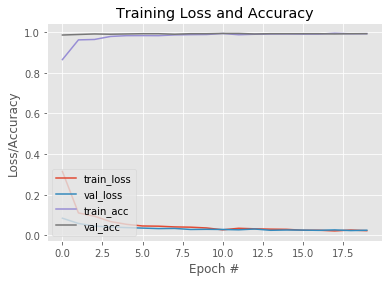

In [16]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [38]:
import cv2
image = load_img('dataset/with_mask/0_0_1 copy 36.jpg', target_size=(224, 224))
image = img_to_array(image)
normalized_img = image/255.0
reshaped_img = np.reshape(normalized_img,(1,224,224,3))
image = preprocess_input(reshaped_img)
result=model.predict(image)
result[0]

ValueError: in user code:

    c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1150 predict_function  *
        outputs = self.distribute_strategy.run(
    c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1125 predict_step  **
        return self(x, training=False)
    c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\network.py:717 call
        return self._run_internal_graph(
    c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    c:\users\saikat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer Conv1_pad is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [32, 224, 3]
